In [57]:

import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import joypy as jp
import sympy as sym
from time import time
#sym.init_printing()

#from pysde import *
from functools import partial
from math import log
from matplotlib.colors import LogNorm
from scipy.integrate import odeint
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from mpl_toolkits.mplot3d import Axes3D

from collections import Counter


import seaborn as sns
sns.set_style('ticks')

In [2]:

gamma = 0.0138172

ribo_decay = 6.205e-6
prot_decay = 6.205e-6

r_R = 63
r_P = 63
l_R = 5000
l_P = 975

LHS = np.array([[1,1,1,0],
               [0,0,0,1]])

RHS = np.array([[2,1,0,0],
               [0,1,0,0]])

S = RHS - LHS

    

In [3]:
def reaction_rates(volume, X, mu_ribo_synth= gamma*r_R/l_R, mu_prot_synth= (1-gamma)*r_P/l_P, mu_ribo_decay= ribo_decay, mu_prot_decay= prot_decay):
    
    mu_vector = np.array([mu_ribo_synth, mu_prot_synth, mu_ribo_decay, mu_prot_decay])
    scaled_rates = np.power(X.repeat(LHS.shape[1],1)/volume,LHS).prod(axis=0)
    
    return mu_vector * scaled_rates * volume



In [4]:
def dZ_dt(state, t=0, volume=1e-18):
    
    Z = state.reshape(2*LHS.shape[0]+1, LHS.shape[0])
    
    phi = np.atleast_2d(Z[0]).T
    F = reaction_rates(volume = 1e-18, X=X)
    E = S @ np.diag(F)
    J = (1/X @ F.reshape(1,-1) * LHS).T
    A = S @ J
    
    V = Z[1:A.shape[0]+1]
    G = Z[A.shape[0]+1:]
    
    phidot = S @ F
    Vdot = A @ V + V @ A.T + E @ E.T
    Gdot = A @ G
    
    ode_list = np.vstack((phidot, Vdot, Gdot)).reshape(-1)
    
    return ode_list


In [40]:
.

array([[1],
       [2]])

In [67]:
class Trajectory:
    
    def get_init_counts(self, volume):
        if False:
            n_ribo = (7.280245377599019e21*(1 + 1.3322199014570686e-12/
                volume**0.6454883435592754)*volume**0.6971221467560254)/(-5000*(1 +
                 1.3322199014570686e-12/volume**0.6454883435592754) + 
              1.3525663798553437e-6/volume**0.6454883435592754)

            n_prot = 7.466918335998994e18*(volume**0.6971221467560254)
        else:
            n_ribo, n_prot = 10e25 * volume, 10e25 * volume

        return n_ribo, n_prot

    def get_div_time(self, volume):
        if False:
            return 1.4881390043125451e-8/volume**0.6454883435592754
        else:
            return 10000.

    def __init__(self, volume=1e-18, iterations=100000):
        self.volume = volume
        self.iterations = iterations
        
        init_counts = np.array(self.get_init_counts(volume))
        global_init = np.vstack([init_counts.reshape(1,2), np.identity(2), np.identity(2)])

        T = np.linspace(0,self.get_div_time(volume),iterations)

        solved_odes = odeint(dZ_dt, y0=global_init.reshape(-1), t=T, args=(volume,)).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])

        n_species = len(init_counts)
        self.X_t = solved_odes[:,0,:]
        self.V_t = solved_odes[:,1:n_species+1,:]
        self.G_t = solved_odes[:,n_species+1:,:]
        self.cov_t = self.V_t[0] @ self.G_t.transpose(0,2,1)

        self.var_ribo = self.V_t[:,0,0]
        self.var_prot = self.V_t[:,1,1]
        self.cov_riboprot = self.V_t[:,0,1]

        self.cov_ribo_over_time = self.cov_t[:,0,0]
        self.cov_prot_over_time = self.cov_t[:,1,1]
        self.cov_riboprot_over_time = self.cov_t[:,0,1]

        self.rho_ribo = np.array([self.cov_ribo_over_time[t]/(np.sqrt(self.var_ribo[0])*np.sqrt(self.var_ribo[t])) for t in range(0,iterations)])
        self.rho_prot = np.array([self.cov_prot_over_time[t]/(np.sqrt(self.var_prot[0])*np.sqrt(self.var_prot[t])) for t in range(0,iterations)])

        self.mi_ribo = -0.5*np.log(1-self.rho_ribo**2)# if rho**2 != 1 else np.inf
        self.mi_prot = -0.5*np.log(1-self.rho_prot**2)
        
        
    def contour(self, fractions=20):
        index_correction = np.zeros(fractions)
        index_correction[-1] = -1
        indices = (np.linspace(0,1,fractions) * self.iterations + index_correction).astype('int')

        plt.subplots(1, figsize=(10,10))

        x_contour = np.linspace(np.min(self.X_t[:,0])*0.9,np.max(self.X_t[:,0])*1.1,100)
        y_contour = np.linspace(np.min(self.X_t[:,1])*0.9,np.max(self.X_t[:,1])*1.1,100)
        x_contour, y_contour = np.meshgrid(x_contour, y_contour)
        points_contour = np.stack((x_contour, y_contour), axis=-1)


        z_contours = [scipy.stats.multivariate_normal(mean=self.X_t[i], cov=self.V_t[i]).pdf(points_contour) for i in indices] 


        for i,z in enumerate(z_contours):
            plt.contour(x_contour, y_contour, z)
            plt.annotate('t= {}'.format("{:.2}".format(self.get_div_time(self.volume)*indices[i]/1e6) ),self.X_t[indices[i]]*np.array([0.95,1.1]), size=8)

        plt.xlabel('Number of ribosomes')
        plt.ylabel('Number of proteins')

#        plt.show()



        


In [6]:
traj =Trajectory(volume=0.001)

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


(100000, 2, 2)


/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


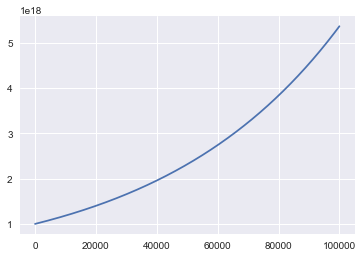

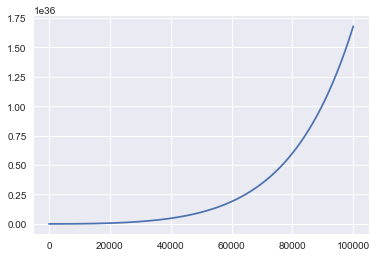

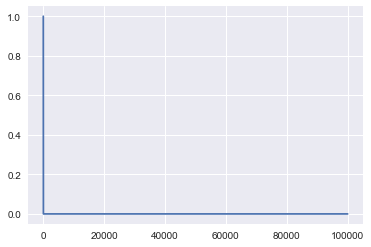

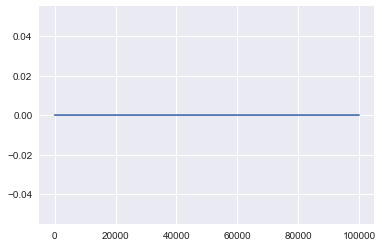

In [7]:
print(traj.V_t.shape)
plt.figure()
plt.plot(traj.X_t[:,0])

plt.figure()
plt.plot(traj.cov_riboprot[:])

plt.figure()
plt.plot(traj.rho_ribo[:])

#print(traj.rho_ribo[90000:])
plt.figure()
plt.plot(-0.5*np.log(1-traj.rho_ribo**2))


In [68]:
trajectories_by_volume = [Trajectory(volume=v) for v in np.logspace(-22,-10,10)]

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


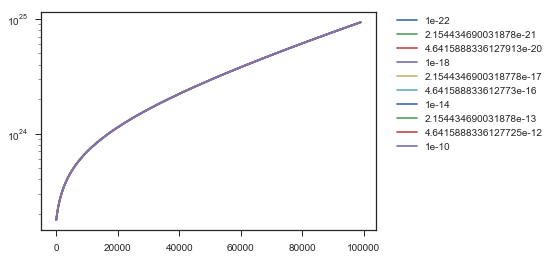

In [87]:
for i,traj in enumerate(trajectories_by_volume):
    plt.plot(np.sqrt(traj.V_t[1000:,0,0])/traj.volume, label=traj.volume)
    #break
#plt.xlim([10000,plt.xlim()[1]])
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

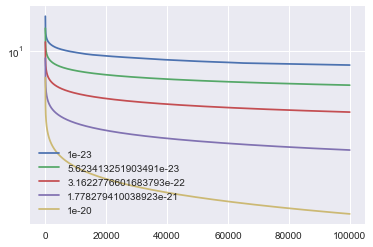

In [10]:
for traj in trajectories_by_volume:
    plt.plot(traj.mi_ribo, label=traj.volume)
    plt.yscale('log')
    plt.legend()
plt.show()

In [11]:
X_t = testres[:,0,:]
V_t = testres[:,1:A.shape[0]+1,:]
G_t = testres[:,A.shape[0]+1:,:]
cov_t = V_t[0] @ G_t.transpose(0,2,1)

NameError: name 'testres' is not defined

In [ ]:
var_ribo = V_t[:,0,0]
var_prot = V_t[:,1,1]
cov_riboprot = V_t[:,0,1]

In [ ]:
cov_ribo_over_time = cov_t[:,0,0]
cov_prot_over_time = cov_t[:,1,1]
cov_riboprot_over_time = cov_t[:,0,1]


In [ ]:
rho_ribo_t = np.vectorize(lambda  t : cov_ribo_over_time[t]/(np.sqrt(var_ribo[0])*np.sqrt(var_ribo[t])))
rho_prot_t = np.vectorize(lambda  t : cov_prot_over_time[int(t)]/(np.sqrt(var_prot[0])*np.sqrt(var_prot[int(t)])))


def mutual_info(t, species): 
    
        if species=='ribo':
            rho = cov_ribo_over_time[t]/(np.sqrt(var_ribo[0])*np.sqrt(var_ribo[t])) 
        elif species=='prot':
            rho = cov_prot_over_time[t]/(np.sqrt(var_prot[0])*np.sqrt(var_prot[t])) 
        
        mutual_info = -0.5*np.log(1-rho**2) if rho**2 != 1 else np.inf
        return mutual_info

    
mutual_info = np.vectorize(mutual_info)
mi_ribo = mutual_info(np.arange(1,1000000), species='ribo')
mi_prot = mutual_info(np.arange(1,1000000), species='prot')

In [ ]:
fig, axes = plt.subplots(2)

axes[0].plot(mi_ribo)
axes[1].plot(mi_prot)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
plt.show()

In [ ]:
plt.plot(cov_ribo_over_time, label='Cov')
plt.plot(var_ribo*var_ribo[0], label='Var ribo')
plt.legend()
plt.show()

In [ ]:
plt.plot(cov_prot_over_time, label='Cov')
plt.plot(var_prot, label='Var prot')
plt.legend()
plt.show()

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log
/Users/nico/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


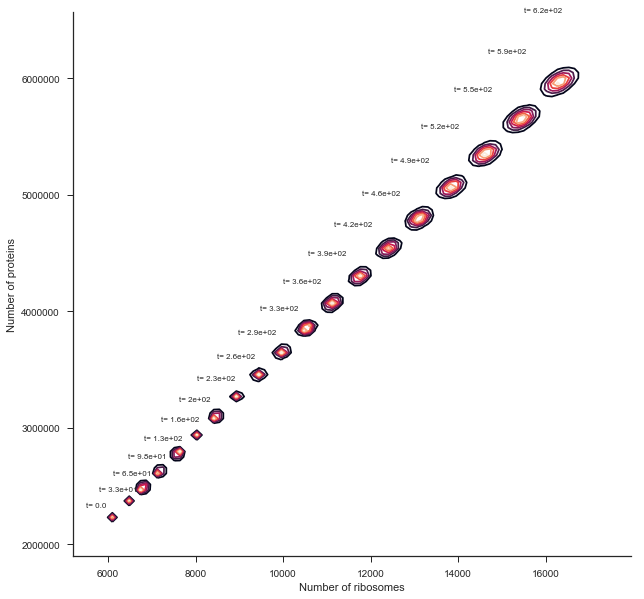

In [62]:
Trajectory(1e-18, iterations=100000).contour()
sns.despine()

In [ ]:
z_contour = scipy.stats.multivariate_normal(mean=X_t[-1], cov=V_t[-1]).pdf(points_contour)#[16300,5.970e6])

In [ ]:
iterations = 1000000
fractions = 20
index_correction = np.zeros(fractions)
index_correction[-1] = -1
indices = (np.linspace(0,1,fractions) * iterations + index_correction).astype('int')

plt.subplots(1, figsize=(10,10))

x_contour = np.linspace(np.min(X_t[:,0])*0.9,np.max(X_t[:,0])*1.1,100)
y_contour = np.linspace(np.min(X_t[:,1])*0.9,np.max(X_t[:,1])*1.1,100)
x_contour, y_contour = np.meshgrid(x_contour, y_contour)
points_contour = np.stack((x_contour, y_contour), axis=-1)


z_contours = [scipy.stats.multivariate_normal(mean=X_t[i], cov=V_t[i]).pdf(points_contour) for i in indices] 


for i,z in enumerate(z_contours):
    plt.contour(x_contour, y_contour, z)
    plt.annotate('t= {}'.format("{:.2}".format(div_time_volume(1e-18)*indices[i]/1e6) ),X_t[indices[i]]*np.array([1,1.1]), size=8)

plt.xlabel('Number of ribosomes')
plt.ylabel('Number of proteins')

plt.show()

In [ ]:
np.max(X_t[:,0])*1.1

In [ ]:
"{:.2E}".format(div_time_volume(1e-18)*indices[0])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for i,z in enumerate(z_contours):
    ax.plot_surface(x_contour, y_contour, z, cmap='coolwarm', alpha=0.4)
    #plt.annotate('t= {}'.format("{:.2}".format(div_time_volume(1e-18)*indices[i]/1e6) ),X_t[indices[i]]*np.array([1,1.1]), size=8)

plt.show()

In [ ]:
1e3

In [ ]:

def dphi_dt(X, t=0):
    #X[0] = [ribosomes](t)
    #X[1] = [proteins](t)
    F = reaction_rates(volume = 1e-18, X=np.atleast_2d(X).T)
    return np.array([S @ F, np.identity(2)])

In [ ]:
A[0] @ np.eye(2) + np.eye(2)[0] @ A.T + E[0] @ E.T

In [ ]:
riboprot_init = np.array([n_ribo_volume(1e-18), n_prot_volume(1e-18)])
global_init = np.array([riboprot_init,np.identity(2)])
odeint(dphi_dt, global_init, t=np.linspace(0,div_time_volume(1e-18),1e6))

In [ ]:
ribo_t, prot_t = odeint(dphi_dt, np.array([n_ribo_volume(1e-18), n_prot_volume(1e-18)]), t=np.linspace(0,div_time_volume(1e-18),1e6)).T
#plt.yscale('log')

In [ ]:
plt.plot(ribo_t)
plt.show()

In [ ]:
scipy.stats.multivariate_normal(cov=np.array([[20,2],[3,2]]),mean=[2,2]).cov